In [5]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# Run two times to bring the files to kaggle folder
import kagglehub
sshikamaru_glaucoma_detection_path = kagglehub.dataset_download('sshikamaru/glaucoma-detection')

print('Data source import complete.')


Using Colab cache for faster access to the 'glaucoma-detection' dataset.
Data source import complete.


In [2]:
import os
import shutil

# 2. 定义您想要存放数据集的目标文件夹
target_dir = '/content/kaggle/input/glaucoma-detection'

# 检查目标文件夹是否存在，如果不存在则创建
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# 3. 移动文件/文件夹
try:
    # 注意：sshikamaru_glaucoma_detection_path 可能是数据集根目录
    shutil.move(sshikamaru_glaucoma_detection_path, target_dir)
    print(f"✅ 数据集已成功移动到: {target_dir}")
except Exception as e:
    print(f"❌ 移动文件时发生错误: {e}")

✅ 数据集已成功移动到: /content/kaggle/input/glaucoma-detection


In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import ndimage
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
meta = pd.read_csv("/kaggle/input/glaucoma-detection/glaucoma.csv")
meta

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0
...,...,...,...,...,...
645,646.jpg,0.6560,OD,A,1
646,647.jpg,0.7365,OD,A,1
647,648.jpg,0.5101,OS,A,1
648,649.jpg,0.5227,OD,B,0


In [ ]:
meta["Glaucoma"].value_counts()

,count
Glaucoma,
0,482
1,168


In [7]:
all_images = glob("/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images/*.jpg")
root = "/kaggle/input/glaucoma-detection/ORIGA/ORIGA/Images"
meta["Path"] = meta["Filename"].apply(lambda fn: os.path.join(root, fn))
meta.head()

,Filename,ExpCDR,Eye,Set,Glaucoma,Path
0,001.jpg,0.7097,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
1,002.jpg,0.6953,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
2,003.jpg,0.9629,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
3,004.jpg,0.7246,OD,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...
4,005.jpg,0.6138,OS,A,0,/kaggle/input/glaucoma-detection/ORIGA/ORIGA/I...


In [ ]:
meta.groupby("Glaucoma")["ExpCDR"].mean()

,ExpCDR
Glaucoma,
0,0.542243
1,0.674040


### Visualize Fondus Images

(3072, 2048)


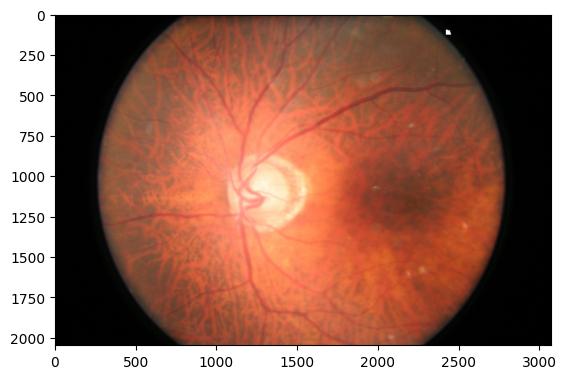

In [ ]:
image = Image.open(all_images[0])
print(image.size)
plt.imshow(image)

In [8]:
def gamma_correct(img, gamma=0.4):
    img = img.astype(np.uint8)
    lookUpTable = np.empty((1,256), np.uint8)

    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    out = cv2.LUT(img, lookUpTable)
    return out

def clahe(image, cl=2.0, tgs=8):
    clahe = cv2.createCLAHE(clipLimit=cl, tileGridSize=(tgs, tgs))
    cl1 = clahe.apply(image)
    return cl1

def clahe_rgb(img, cl=2.0, tgs=8):
    g, b, r = cv2.split(img)
    g, b, r = clahe(g), clahe(b), clahe(r)
    return cv2.merge([g, b, r])

def apply_gaussian(img):
    img = cv2.GaussianBlur(img, (5,5), 0)
    return img

def get_bounding_box(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return [x, y, w, h]

def remove_black_padding(img, threshold):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    # finding the biggest box and it's corresponding bboxes
    x, y, w, h = get_bounding_box(th)

    c_size = 300
    final_size = 384

    images = []

    for i, image in enumerate([clahe(gray), gamma_correct(gray, 3), clahe_rgb(img), img]):

        # removing empty padding and noninformative parts
        crop = image[y+c_size:y+h-c_size, x+c_size:x+w-c_size]

        # resizing to the final size
        crop_resized = cv2.resize(crop, (final_size, final_size))

        if i == 2:
            images.append(crop)

        images.append(crop_resized)

    return images

def crop_cup_disc(img, mask):
    x, y, w, h = get_bounding_box(mask)
    width_ratio = img.shape[1]/mask.shape[1]
    height_ratio = img.shape[0]/mask.shape[0]
    x, w = int(x * width_ratio), int(w * width_ratio)
    y, h = int(y * height_ratio), int(h * height_ratio)

    # Estimated center of the disc
    cx = x + w//2
    cy = y + h//2

    # Cropping a 500 * 500 image that contains the disc
    c_size = 300
    x_start = (cx-c_size) if (cx > c_size) else 0
    y_start = (cy-c_size) if (cy > c_size) else 0
    crop = img[y_start:cy+c_size, x_start:cx+c_size]

    # Resizing to the final size
    final_size = 384
    crop = cv2.resize(crop, (final_size, final_size))

    return crop

In [9]:
def ensure_cluster_groups(data_2d, labels, clusters=4):
    # ensuring the clusters order
    mean_intensities = [data_2d[labels == i].mean() for i in range(clusters)]
    label_map = {i: label for i, label in sorted(enumerate(mean_intensities), key=lambda x: x[1])}
    label_map = {k: i for i, k in enumerate(label_map.keys())}
    mapped_labels = np.vectorize(label_map.get)(labels)
    return mapped_labels

def cluster_image(img):
    slc_image = img

    # clustering
    data_2d = img.reshape(-1, 1)
    kmeans = KMeans(n_clusters=6, n_init=3, random_state=0).fit(data_2d)

    # Reshape the labels back to original shape
    labels = kmeans.labels_
    labels = ensure_cluster_groups(data_2d, labels, 6)
    labels = labels.reshape(img.shape)

    # Create a binary mask by thresholding the brain intensity
    mask = np.isin(labels, [4, 5])
    mask = (mask * 255).astype(np.uint8)

    return mask

In [10]:
def apply_morphology(binary_mask):
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations = 1)

    kernel = np.ones((5,5),np.uint8)
    final = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations = 2)

    return final

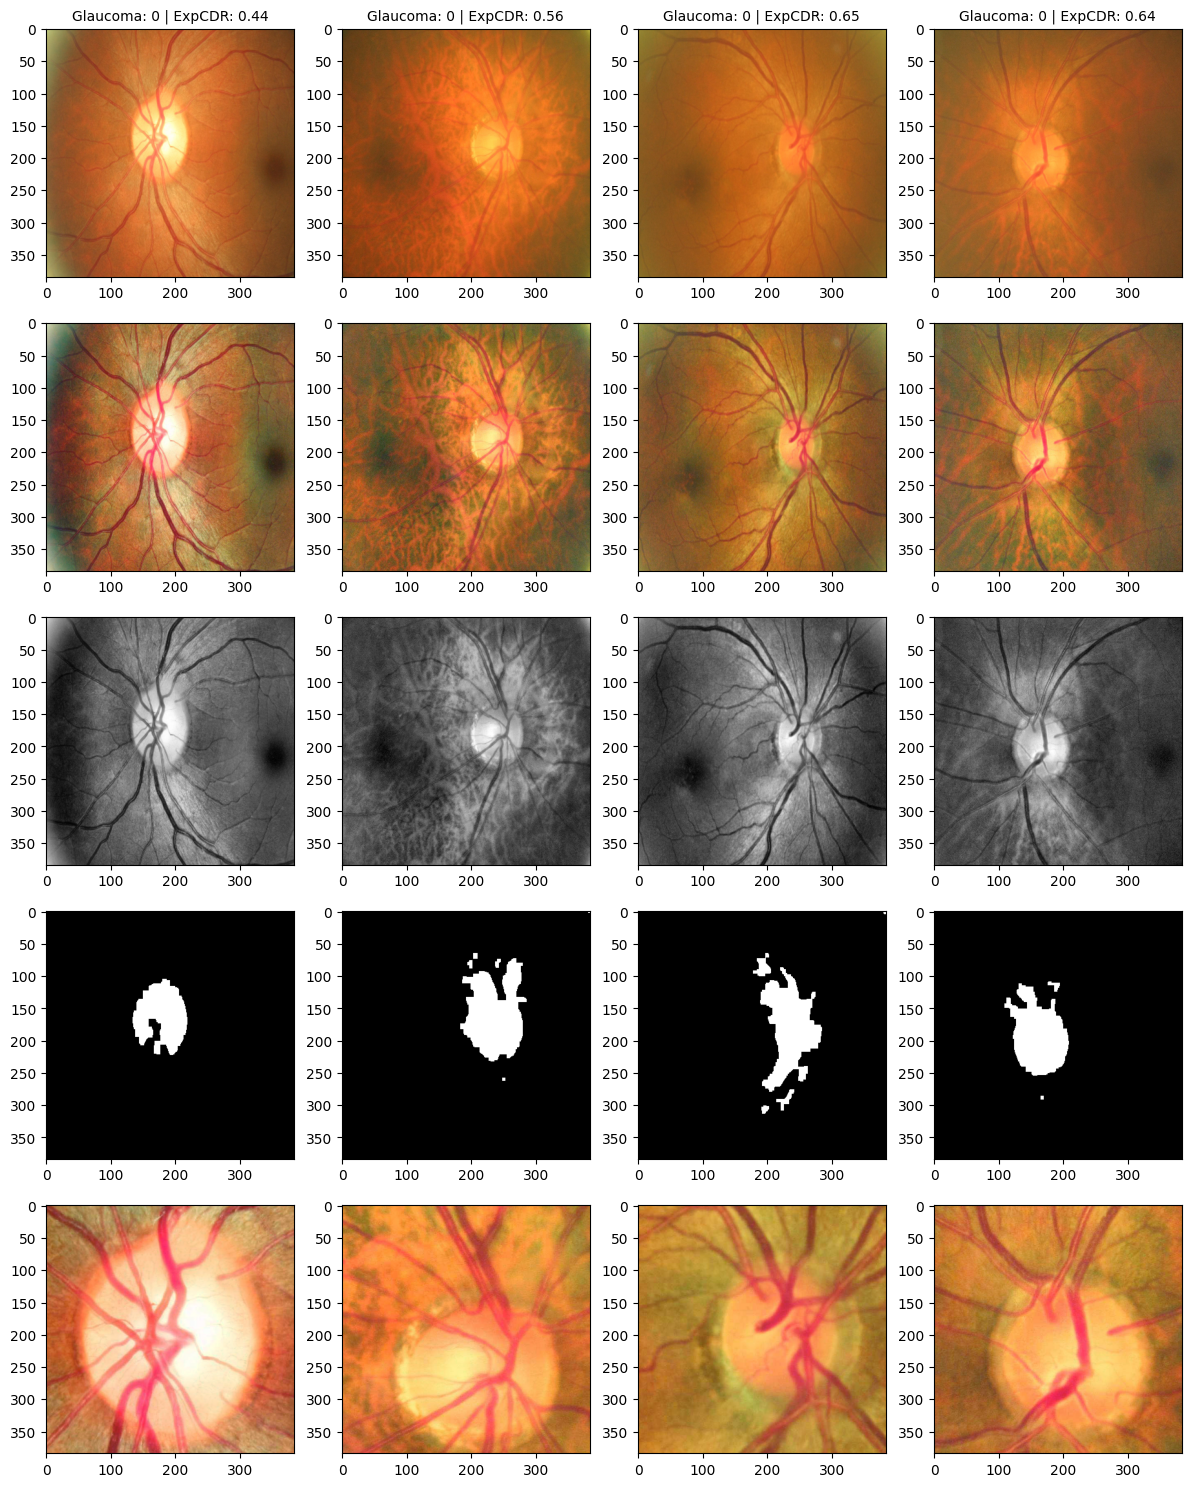

In [11]:
fig, axs = plt.subplots(5, 4, figsize=(12, 15))

for i in range(4):
    path = all_images[160 + i]

    # Finding Glaucoma Dx and ExpCDR
    file_name = Path(path).parts[-1]
    row = meta.loc[meta["Filename"] == file_name].iloc[0]
    gl, exp_cdr = row["Glaucoma"], row["ExpCDR"]

    img = cv2.imread(path)
    clahe_gray, corrected_gray, rgb_clahe_org, rgb_clahe_cropped, rgb_cropped = remove_black_padding(img, 10)

    # Segmenting the disc
    segmented = cluster_image(corrected_gray)
    segmented = apply_morphology(segmented)

    rgb_cup = crop_cup_disc(rgb_clahe_org, segmented)

    axs[0, i].imshow(rgb_cropped[..., ::-1])
    axs[0, i].set_title(f"Glaucoma: {gl} | ExpCDR: {exp_cdr:0.2f}", fontsize=10)
    axs[1, i].imshow(rgb_clahe_cropped[..., ::-1])
    axs[2, i].imshow(clahe_gray, cmap='gray')
    axs[3, i].imshow(segmented, cmap='gray')
    axs[4, i].imshow(rgb_cup[..., ::-1])

plt.tight_layout()
plt.show()

### Save cropped images

In [12]:
from tqdm import tqdm
import os

save_path = "/kaggle/working/cropped_images"
if not os.path.exists(save_path):
    os.makedirs(save_path)

for image_path in tqdm(all_images):
    image_name = Path(image_path).parts[-1]

    new_path = os.path.join(save_path, image_name)

    img = cv2.imread(image_path)
    _, corrected_gray, rgb_clahe_org, _, _ = remove_black_padding(img, 10)

    # Segmenting the disc
    segmented = cluster_image(corrected_gray)
    segmented = apply_morphology(segmented)

    rgb_cup = crop_cup_disc(rgb_clahe_org, segmented)

    cv2.imwrite(new_path, rgb_cup)

100%|██████████| 650/650 [05:27<00:00,  1.99it/s]


In [13]:
save_path = "/kaggle/working/cropped_images"
meta_gl = meta.loc[meta["Glaucoma"] == 0]
meta_nl = meta.loc[meta["Glaucoma"] == 1]
new_meta = pd.concat([meta_gl.iloc[:170], meta_nl]).copy()

In [ ]:
print(len(new_meta))

338


# Preparing data for model training and testing

In [14]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(new_meta, test_size=0.25, random_state=0)
print(train_df.shape, test_df.shape)

(253, 6) (85, 6)


In [15]:
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image

class GlaucomaDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.data = self.get_data()

    def get_data(self):
        data = []
        for i, row in self.df.iterrows():
            label = row["Glaucoma"]
            exp_cdr = row["ExpCDR"]
            name = Path(row["Path"]).parts[-1]
            path = os.path.join(save_path, name)
            data.append(((path, exp_cdr), label))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        (img_path, exp_cdr), label = self.data[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        return (image, torch.FloatTensor([exp_cdr])), label

In [16]:
from torchvision import transforms

train_transforms = transforms.Compose([
    #transforms.Resize((224, 224), antialias=True),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.2),
    transforms.RandomApply([transforms.RandomVerticalFlip()], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the transformations for the test dataset
test_transforms = transforms.Compose([
    #transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [17]:
train_data = GlaucomaDataset(train_df, train_transforms)
test_data = GlaucomaDataset(test_df, test_transforms)

In [18]:
b_size = 16
train_loader = DataLoader(train_data, batch_size=b_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=b_size, shuffle=False)

In [ ]:
one_batch = next(iter(train_loader))

### Visualize a batch

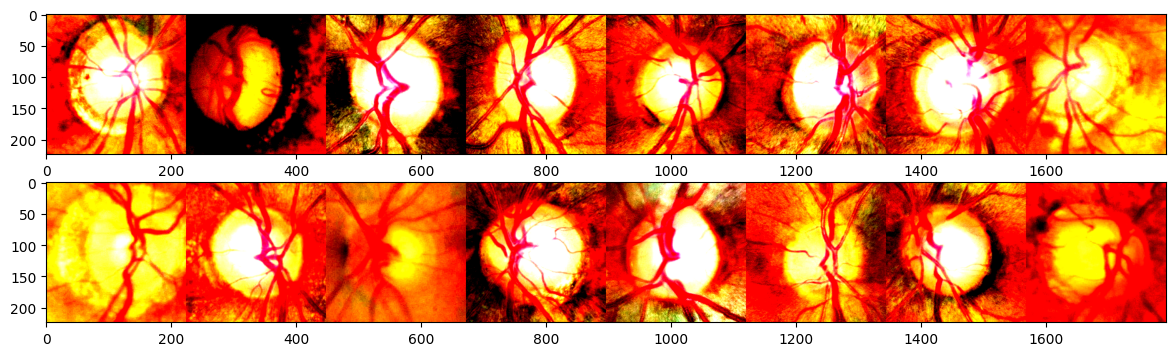

In [ ]:
batch_imgs = one_batch[0][0].numpy()
rows = 2
fig, axs = plt.subplots(rows, 1, figsize=(16, 4))
for i in range(rows):
    img = np.hstack([batch_imgs[j].transpose(1, 2, 0) for j in range(i * (b_size//rows), (b_size//rows) * (i+1))])
    axs[i].imshow(img)
plt.show()

# Model

In [19]:
import torch
from torch import nn
from torchvision import models

class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()

        import torchvision.models as models

        # 加载 ResNet-50，并指定 weights 参数
        # models.ResNet50_Weights.IMAGENET1K_V1 表示加载 ImageNet 上的预训练权重
        self.cnn_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # 然后像之前解释的那样，进行参数冻结和分类层替换：
        for param in self.cnn_model.parameters():
            param.requires_grad = False

        # 替换最后一层 fc，使其输出 30 个特征
        num_features = self.cnn_model.fc.in_features
        self.cnn_model.fc = nn.Linear(num_features, 30)
        # 注意：新创建的 nn.Linear 层的参数默认是 requires_grad=True，因此它不会被冻结，可以正常训练。

        # Feed-forward network for numerical data
        self.ff_model = nn.Sequential(
            nn.Linear(1, 16),  # Assume numerical input has 1 feature
            nn.ReLU(),
            nn.Linear(16, 2)
        )

        self.ff_model.to("cuda:0")

        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 2)  # Assume binary classification
        )

    def forward(self, *x):
        image, exp_cdr = x[0]
        x1 = self.cnn_model(image)
        x2 = self.ff_model(exp_cdr)
        x = torch.cat((x1, x2), dim=1)
        x = self.final_layers(x)
        return x

In [30]:
#试试别的预训练模型
import torch
from torch import nn
import timm

class CombinedModel3(nn.Module):
    def __init__(self):
        super().__init__()
        # 使用 EfficientNet-b0 (或者 b3/b4)
        self.cnn_model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
        # num_classes=0 会移除最后的分类层，直接输出特征

        num_features = self.cnn_model.num_features

        # --- 2. CNN 特征投影层 (新增) ---
        # 将高维的 EfficientNet 特征降维到 30，以匹配您之前的架构设计。
        # 加入了 ReLU 和 Dropout 以增加非线性和防止过拟合。
        self.cnn_projection = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 30)  # 最终输出 30 个特征给下一层
        )
        # Feed-forward network for numerical data
        self.ff_model = nn.Sequential(
            nn.Linear(1, 16),  # Assume numerical input has 1 feature
            nn.ReLU(),
            nn.Linear(16, 2)
        )

        #self.ff_model.to("cuda:0")

        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 2)  # Assume binary classification
        )

    def forward(self, *x):
        image, exp_cdr = x[0]
        x1 = self.cnn_model(image)
        x1 = self.cnn_projection(x1)
        x2 = self.ff_model(exp_cdr)
        x = torch.cat((x1, x2), dim=1)
        x = self.final_layers(x)
        return x

In [32]:
model = CombinedModel3()
model = model.to("cuda:0")

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [44]:
#这个版本不需要手动冻结参数
from fastai.vision.all import *
# 确保引入 LabelSmoothingCrossEntropy，这在医学图像中通常比普通交叉熵更好
from fastai.losses import LabelSmoothingCrossEntropy
from fastai.metrics import accuracy, Recall, Precision, F1Score, RocAucBinary

# 重新定义 Learner
# 建议使用 LabelSmoothingCrossEntropy 提高泛化能力
learner = Learner(DataLoaders(train_loader, test_loader), model,
                  metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
                  loss_func=LabelSmoothingCrossEntropy())

# 定义回调函数 (保持不变)
save_best = SaveModelCallback(
    monitor='f1_score',
    fname='best_efficientnet_glaucoma', # 更改保存的文件名以示区别
)

# 早停耐心值可以稍微增加一点，因为微调需要一些时间来适应
early_stop = EarlyStoppingCallback(
    monitor='f1_score',
    min_delta=0.005,
    patience=15
)

print("开始微调训练...")
# --- 使用 fine_tune 进行两阶段训练 ---
# 阶段 1: 冻结 EfficientNet 主干，只训练自定义的头部 (cnn_projection, ff_model, final_layers) 运行 3 个 epoch。
# 阶段 2: 解冻所有层，使用较低的学习率训练 50 个 epoch (受早停控制)。
# base_lr: 这是第二阶段的最大学习率。第一阶段的学习率默认是它的 1/10。
learner.fine_tune(
    epochs=50,          # 解冻后训练的最大轮数
    base_lr=1e-3,       # 基础学习率
    freeze_epochs=3,    # 冻结训练的轮数
    cbs=[early_stop, save_best]
)

开始微调训练...


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.235410,0.675473,0.776471,0.789474,0.731707,0.759494,0.858903,00:08
1,0.255739,0.549464,0.811765,0.763158,0.805556,0.783784,0.872340,00:08
2,0.287200,0.717474,0.705882,0.631579,0.685714,0.657534,0.776036,00:08


Better model found at epoch 0 with f1_score value: 0.759493670886076.
Better model found at epoch 1 with f1_score value: 0.7837837837837838.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.236481,0.652640,0.752941,0.815789,0.688889,0.746988,0.869541,00:08
1,0.238079,0.667961,0.788235,0.815789,0.738095,0.775000,0.858343,00:08
2,0.230593,0.640189,0.776471,0.815789,0.720930,0.765432,0.858903,00:08
3,0.237526,0.610218,0.764706,0.815789,0.704545,0.756098,0.865622,00:08
4,0.228783,0.624095,0.752941,0.763158,0.707317,0.734177,0.862262,00:08
5,0.223242,0.624930,0.776471,0.815789,0.720930,0.765432,0.888018,00:08
6,0.221557,0.620125,0.776471,0.842105,0.711111,0.771084,0.887458,00:08
7,0.221543,0.544779,0.800000,0.815789,0.756098,0.784810,0.890817,00:08
8,0.219200,0.668113,0.764706,0.631579,0.800000,0.705882,0.852184,00:08
9,0.217506,0.736343,0.764706,0.736842,0.736842,0.736842,0.833147,00:08


Better model found at epoch 0 with f1_score value: 0.7469879518072289.
Better model found at epoch 1 with f1_score value: 0.775.
Better model found at epoch 7 with f1_score value: 0.7848101265822784.
Better model found at epoch 13 with f1_score value: 0.8.
No improvement since epoch 13: early stopping


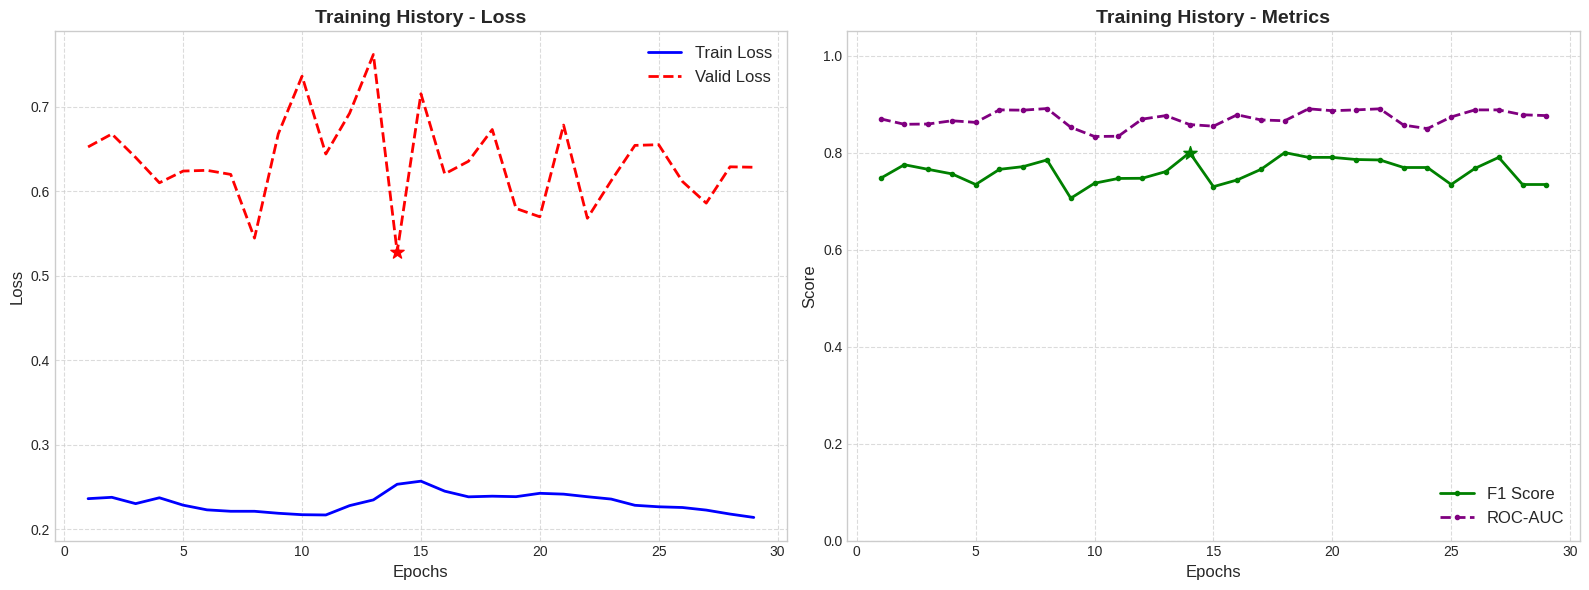

In [56]:
#绘图函数
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(learner,fold,title="Training History"):
    """
    从 FastAI Learner 中提取数据并绘制专业的 Loss 和 Metrics 曲线
    """
    # 1. 提取数据
    # recorder.values 是一个列表，每一行对应一个 epoch
    # 每一行的列顺序对应 learner.recorder.metric_names
    values = np.array(learner.recorder.values)
    metric_names = learner.recorder.metric_names

    # FastAI 的 metric_names 通常是 ['epoch', 'train_loss', 'valid_loss', 'accuracy', 'f1_score', 'roc_auc_binary', ...]
    # 注意：values 里不包含 'epoch' 列，所以索引要偏移

    # 找到对应的索引 (自动查找，防止顺序变动)
    try:
        idx_train_loss = metric_names.index('train_loss') - 1
        idx_valid_loss = metric_names.index('valid_loss') - 1
        idx_f1 = metric_names.index('f1_score') - 1
        idx_auc = metric_names.index('roc_auc_score') - 1
    except ValueError:
        print("错误: 找不到指定的指标名称，请检查 learner.recorder.metric_names")
        print("当前可用指标:", metric_names)
        return

    # 提取列数据
    train_losses = values[:, idx_train_loss]
    valid_losses = values[:, idx_valid_loss]
    f1_scores = values[:, idx_f1]
    auc_scores = values[:, idx_auc]
    epochs = range(1, len(train_losses) + 1)

    # 2. 设置绘图风格
    plt.style.use('seaborn-v0_8-whitegrid') # 使用整洁的网格风格
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- 图 1: Loss 曲线 ---
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, valid_losses, 'r--', label='Valid Loss', linewidth=2)
    ax1.set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # 标记最佳验证 Loss 点
    min_loss_idx = np.argmin(valid_losses)
    ax1.scatter(epochs[min_loss_idx], valid_losses[min_loss_idx], s=100, c='red', marker='*')

    # --- 图 2: Metrics 曲线 (F1 & AUC) ---
    ax2.plot(epochs, f1_scores, 'g-', label='F1 Score', linewidth=2, marker='.')
    ax2.plot(epochs, auc_scores, 'purple', label='ROC-AUC', linewidth=2, linestyle='--', marker='.')

    ax2.set_title(f'{title} - Metrics', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_ylim(0, 1.05) # 固定 y 轴范围 0-1
    ax2.legend(fontsize=12, loc='lower right')
    ax2.grid(True, linestyle='--', alpha=0.7)

    # 标记最佳 F1 点
    max_f1_idx = np.argmax(f1_scores)
    ax2.scatter(epochs[max_f1_idx], f1_scores[max_f1_idx], s=100, c='green', marker='*')
    SAVE_FILENAME = f'/kaggle/working/KFold_Training_Curves_{fold+1}.png'
    plt.savefig(SAVE_FILENAME, dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

# --- 调用绘图函数 ---
# 假设 learner 刚刚训练完，或者你可以 load 一个训练好的 learner
plot_training_history(learner,0)

In [49]:
num_epochs_recorded = len(learner.recorder.values)
print(f"Learner 记录到的总 Epoch 数量: {num_epochs_recorded}")

Learner 记录到的总 Epoch 数量: 29


##K-fold

In [ ]:
#f1_score Fold1:0.79 Fold2:0.81 Fold3:0.94 Fold4
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from fastai.vision.all import *
from pathlib import Path

# 1. 定义你想要的保存目录
OUTPUT_DIR = Path('/kaggle/working')
OUTPUT_DIR.mkdir(exist_ok=True) # 确保目录存在

# --- 1. 参数与数据准备 ---

# 假设你的所有数据都在这个 DataFrame 中，且包含 'label' 和 'path' 列
df = new_meta# 你的完整数据集 DataFrame

N_SPLITS = 5  # K 值，通常使用 5 或 10
RANDOM_STATE = 42
all_fold_metrics = []

# 初始化 KFold 分割器。
# shuffle=True 非常重要，可以打乱数据后再分割。
# StratifiedKFold (分层K折) 更好，因为它能保证每个折叠的标签比例相似。
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)


# --- 2. K-Fold 训练主循环 ---

# kf.split() 返回的是数据的索引
for fold, (train_index, val_index) in enumerate(kf.split(df, df['Glaucoma'])):

    print(f"\n--- 🚀 Starting Fold {fold+1}/{N_SPLITS} ---")

    # A. 划分训练集和验证集的 DataFrame
    train_df = df.iloc[train_index].reset_index(drop=True)
    val_df = df.iloc[val_index].reset_index(drop=True)

    print(f"Fold {fold+1}: Train size={len(train_df)}, Validation size={len(val_df)}")

    # B. 创建数据集和数据加载器 (DataLoaders)
    # ⚠️ 注意：这里需要使用你的 GlaucomaDataset 类
    train_ds = GlaucomaDataset(train_df, train_transforms)
    val_ds = GlaucomaDataset(val_df, test_transforms)

    train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=16)
    dls = DataLoaders(train_dl, val_dl)


    # C. 初始化新模型 (⚠️ 关键步骤！)
    # 每一折都必须重新实例化模型和 Learner，以确保权重是独立的。
    # 使用你当前效果最好的模型架构 (ResNet/EfficientNet)
    torch.cuda.empty_cache() # 清理显存，防止内存溢出
    model = CombinedModel3() # 重新创建模型实例
    model = model.to("cuda:0")


    # D. 设置 Learner 和回调函数
    # 使用你之前定义的指标、Loss和自定义回调 (如 CombinedMixUp)
    # 将模型文件名改为包含 fold 号，方便保存和加载
    learner = Learner(dls, model, path=OUTPUT_DIR,
              metrics=[accuracy, Recall(), Precision(), F1Score(), RocAucBinary()],
              loss_func=LabelSmoothingCrossEntropyFlat()
                    )

    save_cb = SaveModelCallback(monitor='f1_score', fname=f'best_fold_{fold+1}', comp=np.greater)
    early_cb = EarlyStoppingCallback(monitor='f1_score', min_delta=0.005, patience=15)


    # E. 训练和保存最佳模型
    learner.fine_tune(
        epochs=50,
        base_lr=2e-3,
        freeze_epochs=3,
        cbs=[save_cb, early_cb]
    )
    plot_training_history(learner,fold)

    # F. 验证和记录结果
    learner.load(f'best_fold_{fold+1}') # 加载该折的最佳权重
    metrics = learner.validate()

    # 记录该折的 F1Score 和 AUC (假设它们是 metrics 列表中的第三和第四个元素)
    f1_score = metrics[4]
    roc_auc = metrics[5]
    all_fold_metrics.append({'Fold': fold+1, 'F1': f1_score, 'AUC': roc_auc})

    print(f"✅ Fold {fold+1} Completed. F1 Score: {f1_score:.4f}, AUC: {roc_auc:.4f}")


# --- 3. 结果汇总与评估 ---

final_results_df = pd.DataFrame(all_fold_metrics)
print("\n--- K-Fold 最终结果 ---")
print(final_results_df)
print("------------------------")
print(f"平均 F1 Score: {final_results_df['F1'].mean():.4f} ± {final_results_df['F1'].std():.4f}")
print(f"平均 AUC Score: {final_results_df['AUC'].mean():.4f} ± {final_results_df['AUC'].std():.4f}")


--- 🚀 Starting Fold 1/5 ---
Fold 1: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.683097,0.679709,0.588235,0.235294,0.800000,0.363636,0.682526,00:09
1,0.601899,0.676915,0.647059,0.764706,0.619048,0.684211,0.762111,00:09
2,0.566394,0.888145,0.617647,0.647059,0.611111,0.628571,0.737889,00:09


Better model found at epoch 0 with f1_score value: 0.36363636363636365.
Better model found at epoch 1 with f1_score value: 0.6842105263157895.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.362534,0.752392,0.705882,0.647059,0.733333,0.687500,0.787197,00:09
1,0.304021,0.609478,0.764706,0.764706,0.764706,0.764706,0.806228,00:09
2,0.285196,0.695321,0.705882,0.764706,0.684211,0.722222,0.789792,00:10
3,0.274614,0.727338,0.676471,0.705882,0.666667,0.685714,0.765571,00:10
4,0.265467,0.671507,0.691176,0.558824,0.760000,0.644068,0.796713,00:09
5,0.260872,0.738617,0.705882,0.558824,0.791667,0.655172,0.762976,00:09
6,0.259103,0.856614,0.691176,0.441176,0.882353,0.588235,0.756055,00:09
7,0.263867,0.798811,0.720588,0.794118,0.692308,0.739726,0.751730,00:09
8,0.256176,0.745910,0.691176,0.617647,0.724138,0.666667,0.765571,00:09
9,0.258162,0.877520,0.661765,0.529412,0.720000,0.610169,0.715398,00:09


Better model found at epoch 0 with f1_score value: 0.6875.
Better model found at epoch 1 with f1_score value: 0.7647058823529411.
No improvement since epoch 1: early stopping


✅ Fold 1 Completed. F1 Score: 0.7647, AUC: 0.8062

--- 🚀 Starting Fold 2/5 ---
Fold 2: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.689517,0.683050,0.632353,0.352941,0.800000,0.489796,0.742215,00:09
1,0.640203,0.667950,0.617647,0.323529,0.785714,0.458333,0.677336,00:09
2,0.612583,0.675434,0.544118,0.147059,0.714286,0.243902,0.506055,00:09


Better model found at epoch 0 with f1_score value: 0.4897959183673469.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.605904,0.682146,0.705882,0.852941,0.659091,0.743590,0.740484,00:09
1,0.550222,0.588781,0.794118,0.882353,0.750000,0.810811,0.877595,00:09
2,0.523837,0.600421,0.794118,0.764706,0.812500,0.787879,0.808824,00:09
3,0.500558,0.598307,0.735294,0.764706,0.722222,0.742857,0.815744,00:09
4,0.482677,0.628851,0.691176,0.705882,0.685714,0.695652,0.786765,00:09
5,0.468265,0.548951,0.735294,0.529412,0.900000,0.666667,0.903114,00:09
6,0.406936,0.802014,0.764706,0.676471,0.821429,0.741935,0.816609,00:09
7,0.363055,0.692982,0.676471,0.470588,0.800000,0.592593,0.836505,00:09
8,0.354519,0.778993,0.647059,0.470588,0.727273,0.571429,0.814014,00:09
9,0.348633,0.754262,0.735294,0.647059,0.785714,0.709677,0.813149,00:09


Better model found at epoch 0 with f1_score value: 0.7435897435897436.
Better model found at epoch 1 with f1_score value: 0.8108108108108109.
Better model found at epoch 16 with f1_score value: 0.8181818181818182.
Better model found at epoch 25 with f1_score value: 0.8450704225352113.
No improvement since epoch 25: early stopping


✅ Fold 2 Completed. F1 Score: 0.8451, AUC: 0.8936

--- 🚀 Starting Fold 3/5 ---
Fold 3: Train size=270, Validation size=68


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.679836,0.593040,0.735294,0.470588,1.000000,0.640000,0.963668,00:09
1,0.624930,0.641697,0.764706,0.941176,0.695652,0.800000,0.765571,00:09
2,0.616034,0.644596,0.691176,0.411765,0.933333,0.571429,0.802768,00:09


Better model found at epoch 0 with f1_score value: 0.64.
Better model found at epoch 1 with f1_score value: 0.8.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.513681,0.607009,0.882353,0.764706,1.000000,0.866667,0.952422,00:09
1,0.490791,0.502648,0.941176,0.882353,1.000000,0.937500,0.958478,00:09
2,0.460559,0.403791,0.926471,0.911765,0.939394,0.925373,0.981834,00:09
3,0.399706,0.317461,0.941176,0.941176,0.941176,0.941176,0.975779,00:09
4,0.369093,0.362136,0.897059,0.852941,0.935484,0.892308,0.951557,00:09
5,0.341544,0.430075,0.852941,0.852941,0.852941,0.852941,0.930796,00:09
6,0.317597,0.328396,0.926471,0.882353,0.967742,0.923077,0.969723,00:09
7,0.297399,0.483416,0.808824,0.823529,0.800000,0.811594,0.929931,00:09
8,0.283784,0.472728,0.867647,0.735294,1.000000,0.847458,0.932526,00:09
9,0.288588,0.562028,0.779412,0.970588,0.702128,0.814815,0.928201,00:09


Better model found at epoch 0 with f1_score value: 0.8666666666666667.
Better model found at epoch 1 with f1_score value: 0.9375.
Better model found at epoch 3 with f1_score value: 0.9411764705882353.
No improvement since epoch 1: early stopping


✅ Fold 3 Completed. F1 Score: 0.9412, AUC: 0.9758

--- 🚀 Starting Fold 4/5 ---
Fold 4: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.681442,0.670862,0.507463,0.000000,0.000000,0.000000,0.786988,00:09
1,0.638683,0.616650,0.776119,0.848485,0.736842,0.788732,0.857398,00:09
2,0.588742,0.688504,0.716418,0.545455,0.818182,0.654545,0.754902,00:09


Better model found at epoch 0 with f1_score value: 0.0.
Better model found at epoch 1 with f1_score value: 0.7887323943661971.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.412681,0.433664,0.880597,1.000000,0.804878,0.891892,0.934046,00:09
1,0.342670,0.412881,0.895522,0.878788,0.906250,0.892308,0.937611,00:09
2,0.300010,0.438306,0.895522,0.909091,0.882353,0.895522,0.914439,00:09
3,0.287640,0.423661,0.880597,0.909091,0.857143,0.882353,0.913547,00:09
4,0.267002,0.603390,0.731343,0.666667,0.758621,0.709677,0.882353,00:09
5,0.259997,0.524577,0.835821,0.878788,0.805556,0.840580,0.897504,00:09
6,0.260847,0.525310,0.791045,0.727273,0.827586,0.774194,0.895722,00:09
7,0.266416,0.523664,0.850746,1.000000,0.767442,0.868421,0.959002,00:09
8,0.262749,0.443839,0.880597,0.939394,0.837838,0.885714,0.942068,00:09
9,0.271861,0.568201,0.776119,0.969697,0.695652,0.810127,0.923351,00:09


Better model found at epoch 0 with f1_score value: 0.8918918918918919.
Better model found at epoch 1 with f1_score value: 0.8923076923076924.
Better model found at epoch 2 with f1_score value: 0.8955223880597015.
Better model found at epoch 12 with f1_score value: 0.8985507246376812.
No improvement since epoch 12: early stopping


✅ Fold 4 Completed. F1 Score: 0.8986, AUC: 0.9626

--- 🚀 Starting Fold 5/5 ---
Fold 5: Train size=271, Validation size=67


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.684346,0.661544,0.731343,0.545455,0.857143,0.666667,0.860963,00:09
1,0.610195,0.593903,0.865672,0.939394,0.815789,0.873239,0.871658,00:09
2,0.553553,2.714349,0.492537,1.000000,0.492537,0.660000,0.650624,00:09


Better model found at epoch 0 with f1_score value: 0.6666666666666666.
Better model found at epoch 1 with f1_score value: 0.8732394366197183.


epoch,train_loss,valid_loss,accuracy,recall_score,precision_score,f1_score,roc_auc_score,time
0,0.397316,0.511454,0.791045,0.969697,0.711111,0.820513,0.937611,00:09
1,0.314914,0.609900,0.731343,0.909091,0.666667,0.769231,0.901961,00:09
2,0.278275,0.506161,0.791045,0.878788,0.743590,0.805556,0.918895,00:09
3,0.271715,0.607985,0.761194,0.939394,0.688889,0.794872,0.877005,00:09
4,0.255745,0.496209,0.850746,0.848485,0.848485,0.848485,0.896613,00:09
5,0.249453,0.531053,0.820895,0.878788,0.783784,0.828571,0.887701,00:09
6,0.253728,0.462570,0.880597,0.939394,0.837838,0.885714,0.929590,00:09
7,0.262560,0.743380,0.731343,0.969697,0.653061,0.780488,0.884135,00:09
8,0.261575,0.536175,0.835821,0.848485,0.823529,0.835821,0.892157,00:09
9,0.266095,0.524736,0.820895,0.848485,0.800000,0.823529,0.888592,00:09


Better model found at epoch 0 with f1_score value: 0.8205128205128205.
Better model found at epoch 4 with f1_score value: 0.8484848484848485.
Better model found at epoch 6 with f1_score value: 0.8857142857142857.
No improvement since epoch 6: early stopping


✅ Fold 5 Completed. F1 Score: 0.8857, AUC: 0.9296

--- K-Fold 最终结果 ---
   Fold        F1       AUC
0     1  0.764706  0.806228
1     2  0.845070  0.893599
2     3  0.941176  0.975779
3     4  0.898551  0.962567
4     5  0.885714  0.929590
------------------------
平均 F1 Score: 0.8670 ± 0.0667
平均 AUC Score: 0.9136 ± 0.0679
